In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
os.chdir('/Users/stevensuser/Library/CloudStorage/OneDrive-stevens.edu/PhD_research/BB')
ret_cds_df = pd.read_pickle("ret_cds_us_20nan_5_21.pkl")

In [9]:
def eps_ts(ret_data, N, NF):
    """Generate noise time series with same covariance structure as the returns

       Arguments:
            ret_data: time series format dataframe (returns)
            N       : desired length of generated time series
            NF      : number of common factors (<= min(ret_data.shape))

       Returns:
            time series of noise (R tilde)
    """
    u, s, vt = np.linalg.svd(ret_data, full_matrices=False)  # 1a doc
    u_p = u[:, :NF]
    s_p = s[:NF]
    vt_p = vt[:NF, ]

    f_0 = (u_p * s_p) @ vt_p  # 1c doc

    r_tilde = ret_data.reset_index(
    ).iloc[:, 1:] - pd.DataFrame(f_0, columns=ret_data.columns)  # 1d doc

    rand2_df = pd.DataFrame(np.random.normal(
        0, 1, size=(len(ret_data.index), N)))

    eps = (np.dot(rand2_df.T, r_tilde)) / \
        (np.sqrt(len(ret_data.index)))  # 2c doc
    uncor_df = pd.DataFrame(eps, columns=ret_data.columns)

    return uncor_df

In [10]:
def add_adj_noise(adj_mat, uncor_df, alpha, beta, lag):
    """Add adjacency effect to the time series (noise + common factors)

       Arguments:
            adj_mat    : adjacency matrix
            uncor_df   : time series for the adjacency effect to be applied on
            alpha      : ratio of the uncor_df to go through adjacency
            beta       : ratio of the uncor_df to stay without adjacency effect
            lag        : number of days (period) it takes the shock to spread

       Returns:
            time series with adjacency effect
    """
    noise_df = uncor_df*beta  # pure noise
    adj_noise_df = uncor_df*alpha  # input in adj

    # adj[0] to take the first time window only
    adj_noise_df = adj_noise_df@(adj_mat[0])
    adj_noise_df.columns = noise_df.columns  # rename columns to bbid's

    return adj_noise_df.shift(lag).fillna(0) + noise_df.values

In [11]:
def mle_b(data):
    """Compute the OLS for multivariate autoregression

       Arguments:
            data  : time series format data
            
       Returns:
            coefficinets of the model
    """

    x_m = data[:-1].values

    A = np.linalg.pinv(x_m.T@x_m)@x_m.T@data[1:]

    A.index = A.columns

    return A

In [26]:
def leontief_inverse_node(adj_mat):
    """Get the Leontief inverse as centrality measure of the node

       Arguments:
            adj_mat: adjacency 3D array

       Returns:
            the Leontief inverse 3D array for adjacency matrix
    """

    leont = adj_mat.copy()
    #leont = adj_mat[:]
    for i in range(len(adj_mat)):  # for each time window
        eig_mat = np.linalg.eig(adj_mat[i])[0]
        #print(abs(max(eig_mat, key=abs)))

        # identity matrix - number of nodes' size
        iden = np.identity(len(adj_mat[0]))
        dif = iden - adj_mat[i]

        a_inv = np.linalg.inv(dif)
        leont[i][:] = a_inv
    return leont

In [13]:
def leontief_inverse_system(leon_node):
    """Get the Leontief inverse as centrality measure of the system

       Arguments:
            leon_node: Leontief inverse centrality 3D array

       Returns:
            Leontief inverse 2D array of adjacency matrix
    """

    return np.sum(leon_node, axis=-1) - 1  # -1 to exclude the initial shock

In [14]:
def mc_sim_adj_var(ret_data, N, NF, J, rw, lag_g, lag_m, adj_mat, alpha, beta, itera, d, cf):
    """Get adjacency based on multivariate autoregression approach

       Arguments:
            ret_data: time series format dataframe (returns)
            N       : desired length of generated time series
            NF      : number of common factors (<= min(ret_data.shape))
            J       : number of simulations
            rw      : size of time window
            lag_g   : generation lag
            lag_m   : measurement lag
            adj_mat : adjacency 3D array
            alpha   : ratio of the uncor_df to go through adjacency
            beta    : ratio of the uncor_df to stay without adjacency effect
            itera   : higher order value of the adjacency spread (consdier the spread for how many days)
            d       : rolling the window (set to 0 at start)
            cf      : number of common factors (if no factors are considred input None)

       Returns:
            simulated adjacency based on multivariate autoregression approach (dictionary)
    """

    np.random.seed(30)

    for i in range(J):
        if cf is None:
            sim_df = eps_ts(ret_data, N, NF)
            adj_df = add_adj_noise(adj_mat, sim_df, alpha, beta, lag_g)

        sim_pcor = mle_b(adj_df)
        sim_n = sim_pcor.to_numpy()

        if i != 0:
            sim_fin = np.append(sim_fin, [sim_n], axis=0)
        else:
            sim_fin = [sim_n]

    fin_dict = {}
    fin_dict["sim_df"] = sim_fin

    return fin_dict

In [27]:
def leon_real_sim_plot_normal(mc_sim, adj_mat):
    """Plot system's leontief centrality for true and simulated time sereis - normalized

       Arguments:
            mc_sim : simulated dictionary
            mode   : network construction approach
            adj_mat: true adjacency matrix

       Returns:
            plot of normalized real and averaged simulated system Leontief centrality
    """
    
    leon_mc_each = leontief_inverse_node(mc_sim["sim_df"])
    leon_mc_sys = leontief_inverse_system(leon_mc_each)
    
    lm = np.mean(leon_mc_sys, axis = 0)
    lmn = lm/abs(max(lm, key=abs))
    
    ll = leontief_inverse_system(leontief_inverse_node(np.array([adj_mat]))).flatten()
    lln = ll/abs(max(ll, key=abs))
    
    plt.plot(lmn, label="Simulated", alpha=.7, color="C0")
    plt.plot(lln, label="Real", alpha=.7, color="C5")
    plt.xlabel("Node")
    plt.ylabel("Leontief centrality")
    plt.title("System's Leontief centrality for the network")
    plt.legend();

## Question 1

In [70]:
def error_prop(mc_sim, adj_mat):
    """Get the error term in Leontief centrality node level

       Arguments:
            mc_sim  : simulated dictionary
            adj_mat : true adjacency matrix

       Returns:
            difference between the simulated and true leontief inverse matrix per simulation (node level)
    """

    leon_mc_each = leontief_inverse_node(mc_sim["sim_df"])  # sim
    le = leontief_inverse_node(np.array([adj_mat]))  # true
    le_resh = le.reshape(len(le[0,1]), len(le[0,1]))
    er = leon_mc_each - le_resh
    b = er + le_resh
    #print(np.allclose(leon_mc_each, b))

    return er

In [166]:
def leon_error_plot(mc_leon_node, adj_mat, mc_sim):
    """Plot system's leontief centrality for true and simulated time sereis - normalized

       Arguments:
            mc_leon_node : node Leontief inverse 3D array
            adj_mat      : true adjacency matrix

       Returns:
            plot of normalized real and averaged simulated system Leontief centrality
    """

    leon_mc_sys = leontief_inverse_system(mc_leon_node) + 1

    lm = np.mean(leon_mc_sys, axis=0)
    #lmn = lm/abs(max(lm, key=abs))

    ll = leontief_inverse_system(
        leontief_inverse_node(np.array([adj_mat]))).flatten()
    #lln = ll/abs(max(ll, key=abs))

    leon_mc_each = leontief_inverse_node(mc_sim["sim_df"])
    leon_mc_syss = leontief_inverse_system(leon_mc_each)
    ls = np.mean(leon_mc_syss, axis=0)

    plt.plot(lm, label="Error", alpha=.7, color="C0")
    plt.plot(ll, label="Real", alpha=.7, color="C5")
    plt.plot(ls, label="Simulated", alpha=.7, color="C8")
    plt.xlabel("Node")
    plt.ylabel("Leontief centrality")
    plt.title("System's Leontief centrality for the network")
    plt.legend();

In [171]:
adj_mat1 = mle_b(ret_cds_df.iloc[1040:1300, :100])
mc_var_25cf = mc_sim_adj_var(ret_cds_df.iloc[1040:1300, :100], 252, 25, 10000, 251, 1, 1, 
                             np.array([adj_mat1]), 1, 1, 50, 0, None)
mc_var_0cf = mc_sim_adj_var(ret_cds_df.iloc[1040:1300, :100], 252, 0, 10000, 251, 1, 1,
                            np.array([adj_mat1]), 1, 1, 50, 0, None)

err_25cf = error_prop(mc_var_25cf, adj_mat1)
err_0cf = error_prop(mc_var_0cf, adj_mat1)

True
True


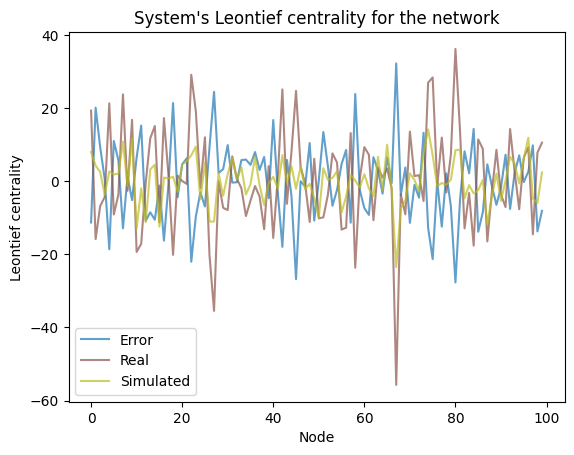

In [167]:
leon_error_plot(err_25cf, adj_mat1, mc_var_25cf)

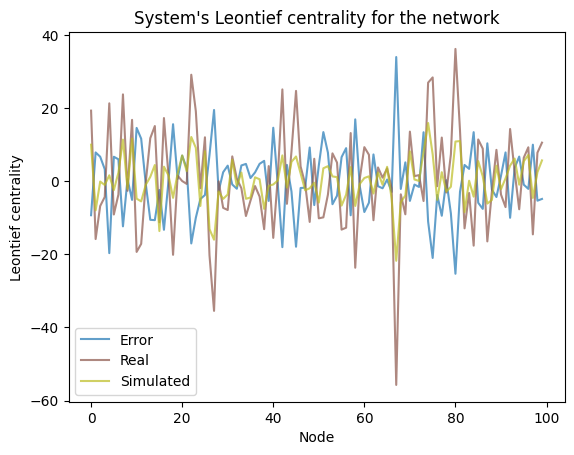

In [168]:
leon_error_plot(err_0cf, adj_mat1, mc_var_0cf)

# Question 2

In [23]:
adj_mat1_10 = mle_b(ret_cds_df.iloc[1040:1300, :10])
mc_var_25cf_10 = mc_sim_adj_var(ret_cds_df.iloc[1040:1300, :10], 252, 25, 10000, 251, 1, 1, 
                             np.array([adj_mat1_10]), 1, 1, 50, 0, None)
mc_var_0cf_10 = mc_sim_adj_var(ret_cds_df.iloc[1040:1300, :10], 252, 0, 10000, 251, 1, 1,
                            np.array([adj_mat1_10]), 1, 1, 50, 0, None)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


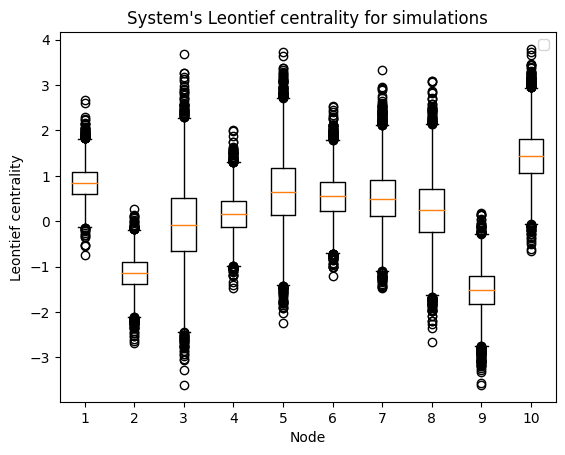

In [169]:
plt.xlabel("Node")
plt.ylabel("Leontief centrality")
plt.title("System's Leontief centrality for simulations")
plt.boxplot(leontief_inverse_system(
    leontief_inverse_node(mc_var_25cf_10["sim_df"])))
plt.legend();

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


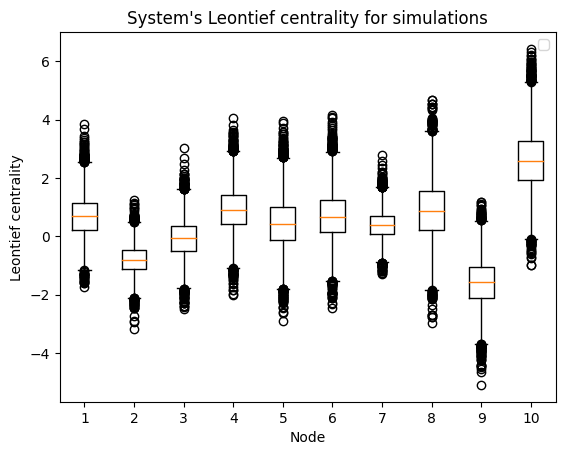

In [170]:
plt.xlabel("Node")
plt.ylabel("Leontief centrality")
plt.title("System's Leontief centrality for simulations")
plt.boxplot(leontief_inverse_system(
    leontief_inverse_node(mc_var_0cf_10["sim_df"])))
plt.legend();